## InvestOps Tutorial 01 - Portfolio Diversification

[Original repository on GitHub](https://github.com/Hvass-Labs/InvestOps-Tutorials)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

----

From [Monty Python's Life of Brian](https://www.youtube.com/watch?v=KHbzSif78qQ):
- Brian: "*You've got to think for yourselves! You're all individuals!*"
- Crowd in unison: "*Yes, we're all individuals!*"
- Brian: "*You're all different!*"
- Crowd in unison: "*Yes, we're all different!*"
- One man: "*I'm not!*"

## Introduction

This tutorial shows how to use the InvestOps function `diversify_weights` for improving the diversification of an investment portfolio, by lowering the correlations between different assets in the portfolio. The method is dubbed "Hvass Diversification" and is described in Section 8 of the [paper](#refs) referenced below. The method is simple, extremely fast to compute, and very robust to estimation errors in the correlation matrix.

Briefly explained, given some portfolio weights of how much we want to invest in each asset, the diversification method calculates the so-called "Full Exposure" of how much the portfolio is actually exposed to each asset, both through the direct investment in each asset, but also through the correlation with other assets in the portfolio. The diversification method then uses a fairly simple and extremely fast algorithm to find new portfolio weights, whose Full Exposure is equal to the originally desired portfolio weights.

Because the diversification method is only allowed to decrease the portfolio weights, the worst that can happen is that it moves too much of the portfolio into cash, which makes it extremely robust to estimation errors in the correlation matrix.

## References <a id="refs"></a>

- M.E.H. Pedersen, "*Simple Portfolio Optimization That Works!*", 2021. ([PDF](https://ssrn.com/abstract=3942552))

## Imports

In [1]:
# If any of these imports fail on Google Colab, then you can
# un-comment the following pip-command to install the packages.
# This is NOT recommended on your local computer, unless you
# have already setup a Python environment for this project.
# See the README on GitHub for detailed instructions.

# !pip install investops numpy pandas matplotlib

In [2]:
# Python packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# InvestOps.
import investops as iv
from investops.diversify import full_exposure, diversify_weights, log_to_dataframe
from investops.random import rand_weights_normal, rand_corr_normal
from investops.normalize import normalize_weights

In [4]:
# InvestOps version.
iv.__version__

'0.1.0'

## Config

In [5]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

## Positive Weights &amp; Correlations

The first example is very simple. We only have 3 assets in the portfolio and all the portfolio weights and correlations are positive.

In [6]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, 0.3])

# Correlation matrix.
corr = np.array([[1.0, 0.5, 0.7],
                 [0.5, 1.0, 0.2],
                 [0.7, 0.2, 1.0]])

In [7]:
# Calculate and show the Full Exposure of the original weights.
full_exposure(weights=weights_org, corr=corr)

array([0.17233688, 0.21771541, 0.32726136])

So the portfolio's Full Exposure is actually 17.2% for Asset 1, 21.8% for Asset 2, and 32.7% for Asset 3, even though the original portfolio weights were only 10%, 20%, and 30%. This is because the Full Exposure measures both the portfolio's direct investment in each asset, as well as the indirect exposure through correlations with other assets in the portfolio.

The goal is then to find new portfolio weights whose Full Exposure is equal to the originally desired portfolio weights, which is done by the function `diversify_weights`.

In [8]:
# Calculate and show the adjusted portfolio weights.
diversify_weights(weights_org=weights_org, corr=corr)

array([0.04349538, 0.18915543, 0.28590522])

So we need to invest about 4.3% of the portfolio in Asset 1, 18.9% in Asset 2, and 28.6% in Asset 3, in order for their Full Exposures to equal the originally desired portfolio weights of 10%, 20%, and 30%.

## Using Asset Names

This example shows how to use the diversification function with Pandas Series and DataFrames instead of Numpy arrays, so we can use names for the assets in the portfolio. This example uses the same portfolio weights and correlation matrix from the previous example.

In [9]:
# Stock-tickers used as the asset names in the portfolio.
names = ['AAPL', 'GOOG', 'MSFT']

In [10]:
# Convert correlation matrix from Numpy to Pandas DataFrame.
df_corr = pd.DataFrame(data=corr, index=names, columns=names)
df_corr

,AAPL,GOOG,MSFT
AAPL,1.0,0.5,0.7
GOOG,0.5,1.0,0.2
MSFT,0.7,0.2,1.0


In [11]:
# Convert original weights from Numpy to Pandas DataFrame.
# It is recommended that you use a Pandas Series instead,
# but if you need to use a DataFrame, it is important that
# it is formatted like this, so it has a single column, the
# rows are the original weights for the different assets,
# and the index of the rows are the asset names.
df_weights_org = pd.DataFrame(data=weights_org, index=names)
df_weights_org

,0
AAPL,0.1
GOOG,0.2
MSFT,0.3


In [12]:
# Convert original weights from Numpy to Pandas Series.
ser_weights_org = pd.Series(data=weights_org, index=names)
ser_weights_org

AAPL    0.1
GOOG    0.2
MSFT    0.3
dtype: float64

In [13]:
# Call the diversifier with the weights being a Pandas Series.
diversify_weights(weights_org=ser_weights_org, corr=df_corr)

AAPL    0.043495
GOOG    0.189155
MSFT    0.285905
dtype: float64

In [14]:
# Call the diversifier with the weights being a Pandas DataFrame.
diversify_weights(weights_org=df_weights_org, corr=df_corr)

AAPL    0.043495
GOOG    0.189155
MSFT    0.285905
dtype: float64

Note that there is some extra overhead in using Pandas data with the `diversify_weights` function, because it checks the data is correct and also converts it to Numpy for internal processing, and then converts the result to a Pandas Series again.

So if you are using the diversification algorithm in a performance-critical application such as back-testing or High-Frequency Trading, then you may want to only pass Numpy arrays to the `diversify_weights` function for faster computation speed.

## Positive / Negative Weights &amp; Correlations

This example has both positive and negative portfolio weights and correlations. Some of the correlations are now deemed "good" and are therefore not included in the calculation of the Full Exposure, see Section 8.3 in the [paper](#refs) for an explanation of this.

In [15]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, -0.3])

# Correlation matrix.
corr = np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

In [16]:
# Calculate and show the Full Exposure of the original weights.
full_exposure(weights=weights_org, corr=corr)

array([ 0.1       ,  0.2059126 , -0.30397368])

In [17]:
# Calculate and show the adjusted portfolio weights.
diversify_weights(weights_org=weights_org, corr=corr)

array([ 0.1       ,  0.19416661, -0.2961424 ])

So we need to invest 10% of the portfolio in Asset 1 which is the same as the originally desired portfolio weight for Asset 1, because its correlations with the other two assets are deemed "good" so they don't require adjustment. But we should only invest 19.4% in Asset 2 and -29.6% in Asset 3. This makes all the Full Exposures equal to the originally desired portfolio weights of 10%, 20%, and -30%.

## "Crazy" Initial Weights

This example uses the same portfolio weights and correlations as in the previous example. But now we supply the diversification algorithm with a guess for the adjusted weights which is just "crazy" wrong. The diversification algorithm handles this very well, and already after the first iteration it has brought the portfolio weights back into a more normal range. See the sub-section titled "Crazy Initialization" in Section 8.12 of the [paper](#refs).

In [18]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, -0.3])

# A "crazy" wrong guess for the adjusted portfolio weights.
weights_guess = np.array([-123, 0.001, -789])

# Correlation matrix.
corr = np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

In [19]:
# Calculate and show the Full Exposure of the guessed weights.
# These are very far from the originally desired portfolio weights.
full_exposure(weights=weights_guess, corr=corr)

array([-2.50363857e+02,  2.49621714e-01, -8.18580516e+02])

In [20]:
# Calculate the adjusted portfolio weights, using weights_guess
# as a starting guess for the adjusted weights. Log all iterations.
log = []
diversify_weights(weights_org=weights_org, corr=corr,
                  weights_guess=weights_guess, log=log)

array([ 0.1       ,  0.19415402, -0.29614218])

In [21]:
# Show the log of all the iterations of weight adjustments.
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,-123.000000,-250.363857,0.001000,0.249622,-789.000000,-818.580516,2.441050e+05
1,0.049128,0.049128,0.001126,0.003844,-0.300000,-0.300023,1.368835e-02
2,0.100000,0.100000,0.058573,0.064272,-0.298835,-0.300005,6.140693e-03
3,0.100000,0.100000,0.182265,0.188099,-0.296406,-0.300029,4.720804e-05
4,0.100000,0.100000,0.193796,0.199631,-0.296152,-0.300003,4.531185e-08
5,0.100000,0.100000,0.194154,0.199989,-0.296142,-0.300000,3.901166e-11


The diversification algorithm corrected the "crazy" wrong guess for the portfolio weights already after the first iteration. The bottom-row of the log shows the same adjusted portfolio weights as in the previous example, which was initialized with the original portfolio weights.

Also note how the Mean Squared Error (MSE) between the Full Exposure and the originally desired weights decrease by several orders of magnitude in most iterations.

## Higher Precision

This example uses the same portfolio weights and correlations as in the previous example, but it uses the default weight-initialization instead of the "crazy" wrong guess. And now we want an even higher precision in the adjusted portfolio weights, so their Full Exposures are even closer to the originally desired weights. This is done by setting the argument `tol` (short for "error **tol**erance") to a value that is close to, but not equal to zero.

In [22]:
# Calculate the adjusted portfolio weights with higher precision.
# Log all iterations.
log = []
diversify_weights(weights_org=weights_org, corr=corr,
                  tol=1e-20, log=log)

array([ 0.1       ,  0.19416484, -0.29614184])

In [23]:
# Show the log of all the iterations of weight adjustments.
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.1,0.1,0.200000,0.205913,-0.300000,-0.303974,1.691634e-05
1,0.1,0.1,0.194257,0.200093,-0.296189,-0.300049,3.691786e-09
2,0.1,0.1,0.194167,0.200002,-0.296142,-0.300001,1.177572e-12
3,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,5.607358e-16
4,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,3.607612e-19
5,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,2.731758e-22
6,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,2.229910e-25
7,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.881639e-28
8,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.615213e-31


Compared to the previous section that used the default argument `tol=1e-3` and which needed 5 iterations of the diversification algorithm to converge, we now need 11 iterations of the algorithm when `tol=1e-20`.

Note that the Mean Squared Error (MSE) decreases by several orders of magnitude in each iteration and eventually becomes zero, which means the Full Exposures have become exactly equal to the originally desired portfolio weights.

## Time Usage

Let us now measure how long it takes to use the diversification algorithm on a portfolio with 1000 assets. We will generate random portfolio weights and correlations.

In [24]:
# Number of assets in the portfolio.
num_assets = 1000

# Originally desired portfolio weights.
# These are randomly generated from a normal distribution.
weights_org = rand_weights_normal(rng=rng, num_assets=num_assets,
                                  mean=0.0, std=0.05,
                                  min_weight=-0.2, max_weight=0.2)

# Correlation matrix randomly generated from a normal distribution.
corr = rand_corr_normal(rng=rng, num_assets=num_assets, mean=0.2)

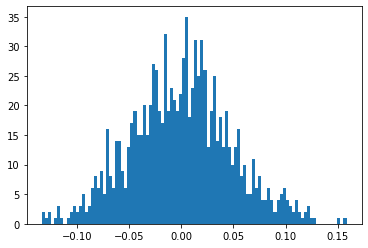

In [25]:
# Histogram of the randomly generated portfolio weights.
plt.hist(weights_org, bins=100);

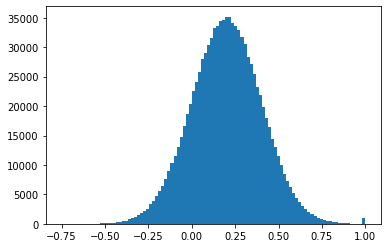

In [26]:
# Histogram of the randomly generated correlation coefficients.
plt.hist(corr.flatten(), bins=100);

In [27]:
%%timeit
# Measure the time-usage of the diversification algorithm.
diversify_weights(weights_org=weights_org, corr=corr)

19.6 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So the diversification algorithm only needed about **20 milli-seconds** to converge to a near-optimal solution for a portfolio with 1000 assets. This was run on a computer with a 2.6 GHz CPU (3.5 GHz boost). The time-usage obviously depends on the number of assets in the portfolio, the weights and correlations, and the speed of the computer.

The time-complexity is quadratic if you hold the error tolerance fixed (which is the `tol` argument in the `diversify_weights` function). This means that for a portfolio of 10,000 assets, you should expect a time-usage of 10\*10\*20 milli-seconds = 2 seconds.

## Compare Weights Before &amp; After

Let us now compare the portfolio weights before and after they were adjusted by the diversification algorithm. This uses the same portfolio weights and correlations that were randomly generated in the previous example.

In [28]:
# Calculate the adjusted portfolio weights.
weights_new = diversify_weights(weights_org=weights_org, corr=corr)

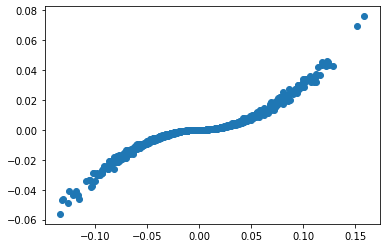

In [29]:
# Scatter-plot of the original portfolio weights on the x-axis
# and the adjusted portfolio weights on the y-axis.
plt.scatter(weights_org, weights_new);

It appears that the diversification algorithm "compresses" the portfolio weights in a smooth but also non-linear way, so the weights that were originally closer to zero get moved dis-proportionally closer to zero. This of course depends on the exact values of the portfolio weights and correlations. It would be an interesting topic for you to research further. Perhaps it could lead to deeper insights into why the diversification algorithm works so well.

## Weight Normalization

The portfolio weights that are output from the function `diversify_weights` are not normalized, so they can sum to more than 1. This example shows how to normalize the portfolio weights using the function `normalize_weights` which can handle both positive and negative weights. We are reusing the weights and correlations from the previous examples.

In [30]:
# Normalize the portfolio weights so the positive weights
# sum to max 1.0, the negative weights sum to min -0.5,
# and the ratio between the sums of positive and negative
# weights is at most 0.2.
weights_norm, cash = \
    normalize_weights(weights=weights_new, limit_pos=1.0,
                      limit_neg=-0.5, max_ratio=0.2)

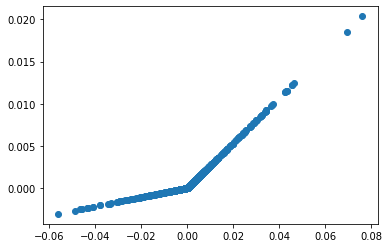

In [31]:
# Show the weights before (x-axis) and after (y-axis) normalization.
plt.scatter(weights_new, weights_norm);

Note that the function `normalize_weights` also accepts input-weights as 2-dimensional Numpy Arrays or Pandas DataFrames, where the rows are for time-steps and the columns are for the different assets. So you can use the function to normalize the weights for many time-steps at once, e.g. for use in back-testing an investing strategy.

## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/InvestOps-Tutorials/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/InvestOps-Tutorials).